In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15,9
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import geopandas as gp
import pandas as pd
from shapely.geometry import Point
from shapely import wkt
from shapely.geometry import Polygon
import json
from folium.plugins import TimeSliderChoropleth

In [3]:
df = pd.read_csv('sensity_events.csv')

In [4]:
df.dropna(axis=0,how='any',inplace=True)
# df.drop(columns='geometry',inplace=True)
df.drop(columns='session_type',inplace=True)

In [5]:
df.drop(columns='uuid',inplace=True)

In [6]:
df.drop(columns='latitude',inplace=True)
df.drop(columns='longitude',inplace=True)

In [7]:
df.rename(columns={'start_time':'start_date','end_time':'end_date'},inplace=True)

In [8]:
df['start_date'] = pd.to_datetime(df.start_date,format='%Y/%m/%d').astype('datetime64[s]')
df['end_date'] = pd.to_datetime(df.end_date,format='%Y/%m/%d').astype('datetime64[s]')

In [9]:
df.head()

asset_id          start_date            end_date  \
0  SENSITY-kc-23 2018-08-10 23:33:26 2018-08-10 23:33:55   
1  SENSITY-kc-22 2018-08-10 23:34:58 2018-08-10 23:36:08   
2  SENSITY-kc-10 2018-08-10 23:33:40 2018-08-10 23:36:25   
3  SENSITY-kc-12 2018-08-10 23:34:44 2018-08-10 23:38:53   
4   SENSITY-kc-9 2018-08-10 23:37:38 2018-08-10 23:39:01   

                                            geometry  
0  {"type":"Polygon","coordinates":[[[-94.5834598...  
1  {"type":"Polygon","coordinates":[[[-94.5807547...  
2  {"type":"Polygon","coordinates":[[[-94.5834062...  
3  {"type":"Polygon","coordinates":[[[-94.5835249...  
4  {"type":"Polygon","coordinates":[[[-94.5836287...

In [10]:
dist_df = df[['asset_id','start_date','end_date','geometry']].drop_duplicates()

In [11]:
df['start_date'] = pd.to_datetime(df.start_date,format='%Y/%m/%d').astype('datetime64[s]')
df['end_date'] = pd.to_datetime(df.end_date,format='%Y/%m/%d').astype('datetime64[s]')

In [12]:
dist_df['start_from_fc']= dist_df.start_date.dt.floor('5min')
dist_df['end_from_fc'] = dist_df.end_date.dt.ceil('5min')

In [13]:
n = (dist_df.end_from_fc - dist_df.start_from_fc)
# n,(n.dt.total_seconds())/60
dist_df['diff'] = (n.dt.total_seconds())/60

In [14]:
dist_df['slots'] = dist_df['diff']/5
dist_df['slots']=dist_df['slots'].astype('int64')
dist_df['bins'] = dist_df.slots.map( lambda x: np.arange(1,x+1,1) if x > 1.0 else np.arange(1,x+1))

In [15]:
dist_df['start'] = dist_df.start_date.dt.date
dist_df['start'] = pd.to_datetime(dist_df.start,format='%Y\%m\%d')

In [16]:
def explode(df, lst_cols, fill_value=''):
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    idx_cols = df.columns.difference(lst_cols)
    lens = df[lst_cols[0]].str.len()
    if (lens > 0).all():
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [17]:
new_df=explode(dist_df, ['bins'], fill_value='')

In [18]:
new_df['bins'] = (new_df.start_from_fc + pd.to_timedelta(5*(new_df['bins']), unit='m'))
new_df['bins1'] = new_df.bins - pd.to_timedelta(5, unit='m')

In [19]:
new_df[new_df.duplicated()]

Empty DataFrame
Columns: [asset_id, start_date, end_date, geometry, start_from_fc, end_from_fc, diff, slots, bins, start, bins1]
Index: []

In [20]:
new_df.groupby(['bins1','bins','asset_id','geometry']).count()[['start_from_fc']]

start_from_fc
bins1               bins                asset_id      geometry                                                         
2018-08-10 23:30:00 2018-08-10 23:35:00 SENSITY-kc-10 {"type":"Polygon","coordinates":[[[-94.58340624...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58340723...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58340879...              1
                                        SENSITY-kc-12 {"type":"Polygon","coordinates":[[[-94.58351305...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58351797...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58352497...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58352696...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58352923...              1
                                        SENSITY-kc-14 {"type":"Polygon","coordinates":[[[-94.58338194...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58338265...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58338927...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58339447...              1
                                        SENSITY-kc-18 {"type":"Polygon","coordinates":[[[-94.58372803...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58372920...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58380697...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58380735...              1
                                        SENSITY-kc-2  {"type":"Polygon","coordinates":[[[-94.58363390...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58363456...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58363955...              1
                                        SENSITY-kc-22 {"type":"Polygon","coordinates":[[[-94.58075470...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58077124...              1
                                        SENSITY-kc-23 {"type":"Polygon","coordinates":[[[-94.58306831...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58345988...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58352863...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58360152...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58367349...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58374716...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58381467...              1
                                                      {"type":"Polygon","coordinates":[[[-94.58388230...              1
                                        SENSITY-kc-8  {"type":"Polygon","coordinates":[[[-94.58349362...              1
...                                                                                                                 ...
2018-11-26 15:35:00 2018-11-26 15:40:00 SENSITY-kc-6  {"type":"Polygon","coordinates":[[[-94.58354635...              1
                          

In [21]:
df_5min = new_df.groupby(['bins1','bins','asset_id','geometry']).count()[['start_from_fc']].add_suffix('_Count').reset_index()

In [22]:
df_5min.head()

bins1                bins       asset_id  \
0 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10   
1 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10   
2 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10   
3 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-12   
4 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-12   

                                            geometry  start_from_fc_Count  
0  {"type":"Polygon","coordinates":[[[-94.5834062...                    1  
1  {"type":"Polygon","coordinates":[[[-94.5834072...                    1  
2  {"type":"Polygon","coordinates":[[[-94.5834087...                    1  
3  {"type":"Polygon","coordinates":[[[-94.5835130...                    1  
4  {"type":"Polygon","coordinates":[[[-94.5835179...                    1

In [23]:
df_5min['geometry'] = df_5min.geometry.apply(lambda x: json.loads(x))

In [24]:
df_5min.head(5)

bins1                bins       asset_id  \
0 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10   
1 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10   
2 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10   
3 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-12   
4 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-12   

                                            geometry  start_from_fc_Count  
0  {'type': 'Polygon', 'coordinates': [[[-94.5834...                    1  
1  {'type': 'Polygon', 'coordinates': [[[-94.5834...                    1  
2  {'type': 'Polygon', 'coordinates': [[[-94.5834...                    1  
3  {'type': 'Polygon', 'coordinates': [[[-94.5835...                    1  
4  {'type': 'Polygon', 'coordinates': [[[-94.5835...                    1

In [25]:
df_5min['temp'] = df_5min.geometry.apply(lambda x: list(x.values())[1][0])

In [26]:
df_5min['poly_latitide']=df_5min.temp.apply(lambda x: list([x[0][0],x[1][0],x[2][0],x[3][0],x[4][0]]))
df_5min['poly_longitude']=df_5min.temp.apply(lambda x: list([x[0][1],x[1][1],x[2][1],x[3][1],x[4][1]]))

In [27]:
df_5min['mc']=(df_5min.apply(lambda x: (list(zip(x[6], x[7]))), axis=1))
df_5min['mc']=df_5min['mc'].apply(Polygon)

In [28]:
df_5min.head()

bins1                bins       asset_id  \
0 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10   
1 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10   
2 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10   
3 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-12   
4 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-12   

                                            geometry  start_from_fc_Count  \
0  {'type': 'Polygon', 'coordinates': [[[-94.5834...                    1   
1  {'type': 'Polygon', 'coordinates': [[[-94.5834...                    1   
2  {'type': 'Polygon', 'coordinates': [[[-94.5834...                    1   
3  {'type': 'Polygon', 'coordinates': [[[-94.5835...                    1   
4  {'type': 'Polygon', 'coordinates': [[[-94.5835...                    1   

                                                temp  \
0  [[-94.5834062421616, 39.09438467559006], [-94....   
1  [[-94.58340723278391, 39.094330998240316], [-9...   
2  [[-94.5834087918651, 39.0942812171699], [-94.5...   
3  [[-94.58351305730527, 39.095150612952516], [-9...   
4  [[-94.58351797524573, 39.095258714384116], [-9...   

                                       poly_latitide  \
0  [-94.5834062421616, -94.58340906848268, -94.58...   
1  [-94.58340723278391, -94.58340922355299, -94.5...   
2  [-94.5834087918651, -94.58340941578419, -94.58...   
3  [-94.58351305730527, -94.58351361678675, -94.5...   
4  [-94.58351797524573, -94.58351876023067, -94.5...   

                                      poly_longitude  \
0  [39.09438467559006, 39.09433597524264, 39.0943...   
1  [39.094330998240316, 39.094287449158564, 39.09...   
2  [39.0942812171699, 39.09424022838295, 39.09424...   
3  [39.095150612952516, 39.095105228331306, 39.09...   
4  [39.095258714384116, 39.09520723787477, 39.095...   

                                                  mc  
0  POLYGON ((-94.5834062421616 39.09438467559006,...  
1  POLYGON ((-94.58340723278391 39.09433099824032...  
2  POLYGON ((-94.5834087918651 39.0942812171699, ...  
3  POLYGON ((-94.58351305730527 39.09515061295252...  
4  POLYGON ((-94.58351797524573 39.09525871438412...

In [29]:
df_5min.drop(columns='poly_latitide',inplace=True)
df_5min.drop(columns='poly_longitude',inplace=True)

In [30]:
df_5min.drop(columns='temp',inplace=True)
df_5min.drop(columns='geometry',inplace=True)

In [31]:
df_5min.head(5)

bins1                bins       asset_id  start_from_fc_Count  \
0 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10                    1   
1 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10                    1   
2 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-10                    1   
3 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-12                    1   
4 2018-08-10 23:30:00 2018-08-10 23:35:00  SENSITY-kc-12                    1   

                                                  mc  
0  POLYGON ((-94.5834062421616 39.09438467559006,...  
1  POLYGON ((-94.58340723278391 39.09433099824032...  
2  POLYGON ((-94.5834087918651 39.0942812171699, ...  
3  POLYGON ((-94.58351305730527 39.09515061295252...  
4  POLYGON ((-94.58351797524573 39.09525871438412...

In [32]:
crs = {'init': 'epsg:4326'}
gdf = gp.GeoDataFrame(df_5min, crs=crs ,geometry='mc')

In [33]:
new_df.loc[(new_df['asset_id']=='SENSITY-kc-23') &\
           (new_df['bins1']=='2018-11-03 21:45:00')\
          & new_df.geometry.str.contains('94.58387299795793')]

asset_id          start_date            end_date  \
1691080  SENSITY-kc-23 2018-11-03 21:44:09 2018-11-03 21:46:02   
1691082  SENSITY-kc-23 2018-11-03 21:45:27 2018-11-03 21:47:02   

                                                  geometry  \
1691080  {"type":"Polygon","coordinates":[[[-94.5838729...   
1691082  {"type":"Polygon","coordinates":[[[-94.5838729...   

              start_from_fc         end_from_fc  diff  slots  \
1691080 2018-11-03 21:40:00 2018-11-03 21:50:00  10.0      2   
1691082 2018-11-03 21:45:00 2018-11-03 21:50:00   5.0      1   

                       bins      start               bins1  
1691080 2018-11-03 21:50:00 2018-11-03 2018-11-03 21:45:00  
1691082 2018-11-03 21:50:00 2018-11-03 2018-11-03 21:45:00

In [34]:
new_df.loc[(new_df['asset_id']=='SENSITY-kc-15') &\
           (new_df.bins1.isin(['2018-09-26 03:20:00','2018-09-26 03:25:00','2018-09-26 03:30:00']))\
          & new_df.geometry.str.contains('94.58354627591267')].sort_values(by=['bins1'],ascending=True)

asset_id          start_date            end_date  \
858195  SENSITY-kc-15 2018-09-26 03:24:15 2018-09-26 03:32:53   
944742  SENSITY-kc-15 2018-09-26 03:23:16 2018-09-26 03:32:53   
858196  SENSITY-kc-15 2018-09-26 03:24:15 2018-09-26 03:32:53   
944743  SENSITY-kc-15 2018-09-26 03:23:16 2018-09-26 03:32:53   
858197  SENSITY-kc-15 2018-09-26 03:24:15 2018-09-26 03:32:53   
944744  SENSITY-kc-15 2018-09-26 03:23:16 2018-09-26 03:32:53   

                                                 geometry       start_from_fc  \
858195  {"type":"Polygon","coordinates":[[[-94.5835462... 2018-09-26 03:20:00   
944742  {"type":"Polygon","coordinates":[[[-94.5835462... 2018-09-26 03:20:00   
858196  {"type":"Polygon","coordinates":[[[-94.5835462... 2018-09-26 03:20:00   
944743  {"type":"Polygon","coordinates":[[[-94.5835462... 2018-09-26 03:20:00   
858197  {"type":"Polygon","coordinates":[[[-94.5835462... 2018-09-26 03:20:00   
944744  {"type":"Polygon","coordinates":[[[-94.5835462... 2018-09-26 03:20:00   

               end_from_fc  diff  slots                bins      start  \
858195 2018-09-26 03:35:00  15.0      3 2018-09-26 03:25:00 2018-09-26   
944742 2018-09-26 03:35:00  15.0      3 2018-09-26 03:25:00 2018-09-26   
858196 2018-09-26 03:35:00  15.0      3 2018-09-26 03:30:00 2018-09-26   
944743 2018-09-26 03:35:00  15.0      3 2018-09-26 03:30:00 2018-09-26   
858197 2018-09-26 03:35:00  15.0      3 2018-09-26 03:35:00 2018-09-26   
944744 2018-09-26 03:35:00  15.0      3 2018-09-26 03:35:00 2018-09-26   

                     bins1  
858195 2018-09-26 03:20:00  
944742 2018-09-26 03:20:00  
858196 2018-09-26 03:25:00  
944743 2018-09-26 03:25:00  
858197 2018-09-26 03:30:00  
944744 2018-09-26 03:30:00

In [35]:
gdf.rename(columns={'bins1':'start_time','bins':'end_time','asset_id':'sensor_id','start_from_fc_Count':'no_of_cars'},inplace=True)

In [36]:
import folium
m = folium.Map([39.10087297922868, -94.58354627591267], zoom_start=5, tiles='cartodbpositron')
folium.GeoJson(gdf.loc[gdf['no_of_cars']>1].mc).add_to(m)
folium.LatLngPopup().add_to(m)
m

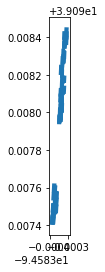

In [37]:
gdf.loc[(gdf['sensor_id']=='SENSITY-kc-14') & (gdf['start_time']=='2018-11-03 13:30:00')].plot()

In [38]:
import folium
# 'Stamen Toner'
#  Stamen Terrain
# Mapbox Bright
# cartodbpositron
m = folium.Map([39.10087297922868, -94.58354627591267], zoom_start=5, tiles='cartodbpositron')
folium.GeoJson(gdf.loc[(gdf['sensor_id']=='SENSITY-kc-14') & (gdf['start_time']=='2018-11-03 13:30:00')].mc).add_to(m)
folium.LatLngPopup().add_to(m)
m

In [39]:
temp_df1=gdf.loc[(gdf['start_time']=='2018-11-03 13:30:00')]
temp_df=gdf.loc[(gdf['sensor_id']=='SENSITY-kc-14') & (gdf['start_time']=='2018-11-03 13:30:00')]
temp_df1['mc1']=temp_df1.mc.apply(lambda x : Point(list(x.exterior.coords)))
from folium import IFrame
from folium.plugins import MarkerCluster
map = folium.Map([39.10087297922868, -94.58354627591267], zoom_start = 14)

def add_point_clusters(mapobj, gdf, popup_field_list):
    #Create empty lists to contain the point coordinates and the point pop-up information
    coords, popups = [], [] 
    #Loop through each record in the GeoDataFrame
    for i, row in gdf.iterrows():
        #Append lat and long coordinates to "coords" list
        coords.append([row.mc1.y, row.mc1.x])
#         coords.append(row.mc1)
        #Create a string of HTML code used in the IFrame popup
        #Join together the fields in "popup_field_list" with a linebreak between them
        label = '<br>'.join([row[field] for field in popup_field_list])
        #Append an IFrame that uses the HTML string to the "popups" list 
        popups.append(IFrame(label, width = 300, height = 100))
        
    #Create a Folium feature group for this layer, since we will be displaying multiple layers
    pt_lyr = folium.FeatureGroup(name = 'pt_lyr')
    
    #Add the clustered points of crime locations and popups to this layer
    pt_lyr.add_children(MarkerCluster(locations = coords, popups = popups))
    
    #Add this point layer to the map object
    mapobj.add_children(pt_lyr)
    return mapobj

#Update choropleth with point clusters
map = add_point_clusters(map, temp_df1, ['sensor_id'])
folium.LayerControl().add_to(map) #Add layer control to toggle on/off
map.save('nov3rd1:30.html') #save HTML
map

/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/ipykernel_launcher.py:26: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
/Users/neerajpadarthi/anaconda3/envs/work/lib/python3.5/site-packages/ipykernel_launcher.py:29: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [40]:
# download countries geojson file
!wget --quiet https://ibm.box.com/shared/static/cto2qv7nx6yq19logfcissyy4euo8lho.json -O world_countries.json
    
print('GeoJSON file downloaded!')

/bin/sh: wget: command not found
GeoJSON file downloaded!


In [56]:
world_geo = r'world_countries.json' # geojson file

# create a plain world map
world_map = folium.Map([39.10087297922868, -94.58354627591267], zoom_start=14, tiles='cartodbpositron')

# generate choropleth map using the total immigration of each country to Canada from 1980 to 2013
world_map.choropleth(
    geo_data=world_geo,
    data=temp_df,
    columns=temp_df.sensor_id,
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.1, 
    line_opacity=0.2,
    legend_name='Immigration to Canada'
)

# display map
world_map

KeyError: 0

In [54]:
temp_df

Empty GeoDataFrame
Columns: [start_time, end_time, sensor_id, no_of_cars, mc]
Index: []

In [57]:
import folium
# 'Stamen Toner'
#  Stamen Terrain
# Mapbox Bright
# cartodbpositron
m = folium.Map([39.10087297922868, -94.58354627591267], zoom_start=5, tiles='cartodbpositron')
colormap = temp_df.linear.Set1_09.scale(0, 35).to_step(10)
colormap.caption = 'A colormap caption'
m.add_child(colormap)
m

AttributeError: 'GeoDataFrame' object has no attribute 'linear'

In [41]:
m = folium.Map([39.10087297922868, -94.58354627591267], tiles='cartodbpositron', zoom_start=9)

folium.GeoJson(
    temp_df.mc,
    style_function=lambda feature: {
        'fillColor': '#FF0000',
        'color': 'black',
        'weight': 3,
        'dashArray': '5,5'
    }
).add_to(m)

# m.save(os.path.join('results', 'Colormaps_0.html'))

m

In [352]:
#gp.overlay(temp_df1, temp_df, how = 'intersection')

In [138]:
g=gdf.loc[(gdf['sensor_id']=='SENSITY-kc-14') & (gdf['start_time']=='2018-11-03 13:30:00') & ()]

In [78]:
h=gdf.loc[(gdf['sensor_id']=='SENSITY-kc-14') & (gdf['start_time']=='2018-11-03 13:30:00')][:50]

In [166]:
g=gdf.loc[1767554:1767554.5][['sensor_id','start_time','end_time','mc']]

In [163]:
crs = {'init': 'epsg:4326'}
gdfh = gp.GeoDataFrame(h, crs=crs ,geometry='mc')

In [167]:
crs = {'init': 'epsg:4326'}
gdfg = gp.GeoDataFrame(g, crs=crs ,geometry='mc')

In [165]:
g

In [168]:
print(gdfg.mc)

1767554    POLYGON ((-94.58334483732568 39.09804596366607...
Name: mc, dtype: object


In [169]:
import folium
# 'Stamen Toner'
#  Stamen Terrain
# Mapbox Bright
# cartodbpositron
m = folium.Map([39.10087297922868, -94.58354627591267], zoom_start=12, tiles='cartodbpositron')
folium.GeoJson(gdfg.mc).add_to(m)
folium.LatLngPopup().add_to(m)
m

In [487]:
# !git clone https://github.com/granularag/pyspatial.git
# !cd pyspatial
# !pip install -r requirements.txt
# !pip install .
# !cd pyspatial
!pwd

/Users/neerajpadarthi/Neeraj/2nd Sem/thesisProject


In [170]:
op= gp.overlay( h,g, how='intersection')

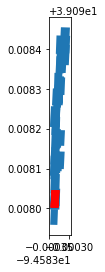

In [174]:
op.plot(ax=h.plot(column = "sensor_id"), color = "red")

In [ ]:
data_overlaps=gp.GeoDataFrame(crs=h.crs)
for index, row in h.iterrows():
    data_temp1=h.loc[h.mc!=row.mc,]
    # check if intersection occured
    overlaps=data_temp1[data_temp1.geometry.overlaps(row.mc)]['mc'].tolist()
    print((overlaps))
    if len(overlaps)>0:
        temp_list=[]
        # compare the area with threshold
        for y in overlaps:
            temp_area=gp.overlay(h.loc[h.mc==y,],h.loc[h.mc==row.mc,],how='difference')
#             temp_area.head(5)
#             temp_area=temp_area.loc[temp_area.geometry.area>=9e-9]
            if temp_area.shape[0]>0:
                print()
                data_overlaps=gp.GeoDataFrame(pd.concat([temp_area,data_overlaps],ignore_index=True),crs=h.crs)
# get unique of list id
# data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['id_1'],y['id_2']]),axis=1)
# data_overlaps['sorted']=data_overlaps.sorted.apply(lambda y: ''.join(y))
# data_overlaps=data_overlaps.drop_duplicates('sorted')
# data_overlaps=data_overlaps.reset_index()[['id_1','id_2','geometry']]

In [218]:
ax=h.plot(figsize=(12, 12),alpha=0.7)
data_overlaps.plot(ax=ax,color='red')

In [75]:
q=gdf.loc[gdf['sensor_id']=='SENSITY-kc-10']
w=gdf.loc[gdf['sensor_id']=='SENSITY-kc-12']

In [76]:
crs = {'init': 'epsg:4326'}
gdfq = gp.GeoDataFrame(q, crs=crs ,geometry='mc')
crs = {'init': 'epsg:4326'}
gdfw = gp.GeoDataFrame(w, crs=crs ,geometry='mc')

In [77]:
op= gp.overlay( gdfq, gdfw, how='intersection')

KeyError: "['__idx1' '__idx2'] not found in axis"

In [261]:
g=gdf.loc[(gdf['sensor_id']=='SENSITY-kc-14') & (gdf['start_time']=='2018-11-03 13:30:00')][2:3]
h=gdf.loc[(gdf['sensor_id']=='SENSITY-kc-14') & (gdf['start_time']=='2018-11-03 13:30:00')][3:4]
# h['__idx1']=""
# h['__idx2']=""
# g['__idx1']=""
# g['__idx2']=""
crs = {'init': 'epsg:4326'}
gdfg = gp.GeoDataFrame(g, crs=crs ,geometry='mc')
gdfh = gp.GeoDataFrame(h, crs=crs ,geometry='mc')

In [262]:
op= gp.overlay( gdfg, gdfh, how='intersection')

In [263]:
op

start_time_1          end_time_1    sensor_id_1  no_of_cars_1  \
0 2018-11-03 13:30:00 2018-11-03 13:35:00  SENSITY-kc-14             1   

         start_time_2          end_time_2    sensor_id_2  no_of_cars_2  \
0 2018-11-03 13:30:00 2018-11-03 13:35:00  SENSITY-kc-14             1   

                                            geometry  
0  POLYGON ((-94.58331542143659 39.09828968722022...

In [264]:
gdfh.geometry.overlaps(gdfg.mc)

1767519    False
1767520    False
dtype: bool

In [265]:
g

start_time            end_time      sensor_id  no_of_cars  \
1767519 2018-11-03 13:30:00 2018-11-03 13:35:00  SENSITY-kc-14           1   

                                                        mc  
1767519  POLYGON ((-94.58331528258682 39.0982896839542,...

In [266]:
h

start_time            end_time      sensor_id  no_of_cars  \
1767520 2018-11-03 13:30:00 2018-11-03 13:35:00  SENSITY-kc-14           1   

                                                        mc  
1767520  POLYGON ((-94.58331664534269 39.09826522440721...

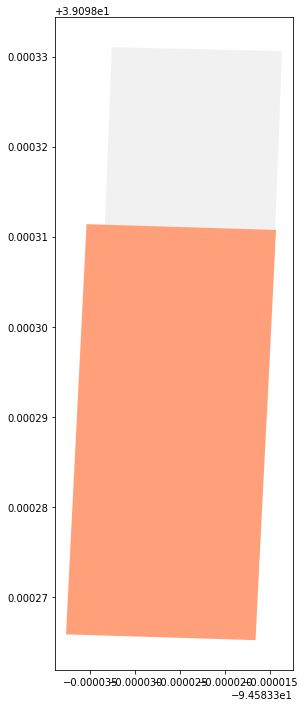

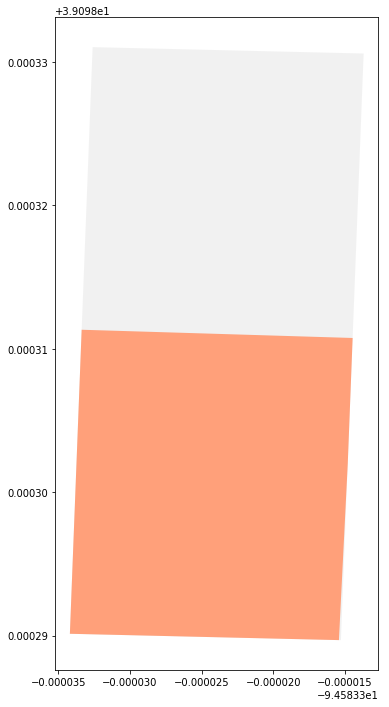

In [268]:
ax=g.plot(figsize=(12, 12),alpha=0.3,color='#D3D3D3')
h.plot(ax=ax,color='#FFA07A')

ax=g.plot(figsize=(12, 12),alpha=0.3,color='#D3D3D3')
op.plot(ax=ax,color='#FFA07A')

# op.plot()

In [432]:
k=gdf.loc[(gdf['sensor_id']=='SENSITY-kc-5') & (gdf['start_time']=='2018-11-03 13:30:00')]
k.insert(0, 'new_id', range(100, 100 + len(k)))
crs = {'init': 'epsg:4326'}
gdfk = gp.GeoDataFrame(g, crs=crs ,geometry='mc')

In [433]:
data_overlaps=gp.GeoDataFrame(crs=k.crs)
for index, row in k.iterrows():
    data_temp1=k.loc[k.new_id!=row.new_id]
    print('data temp1',row.new_id,(data_temp1.new_id).tolist())
    overlaps=data_temp1[data_temp1.geometry.overlaps(row.mc)]['new_id'].tolist()
    print('overlapping data for',row.new_id,overlaps)
    if len(overlaps)>0:
        temp_list=[]
        # compare the area with threshold
        for y in overlaps:
            print(y,row.new_id)
            temp_area=gp.overlay(k.loc[k.new_id==y],k.loc[k.new_id==row.new_id],how='intersection')
#             print([temp_area.new_id_1])
#             print('here ',temp_area.new_id_1)
#             print('here ',temp_area.new_id_2)
            data_overlaps=gp.GeoDataFrame(pd.concat([temp_area,data_overlaps],ignore_index=True),crs=k.crs)
data_overlaps['sorted']=data_overlaps.apply(lambda y: sorted([y['new_id_1'],y['new_id_2']]),axis=1)
data_overlaps['sorted']=data_overlaps.sorted.astype('str').apply(lambda y:' '.join(y))
data_overlaps=data_overlaps.drop_duplicates('sorted')
data_overlaps=data_overlaps.reset_index()[['new_id_1','new_id_2','geometry']]

data temp1 100 [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]
overlapping data for 100 [101, 102, 103, 104]
101 100
102 100
103 100
104 100
data temp1 101 [100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]
overlapping data for 101 [100, 102, 103, 104]
100 101
102 101
103 101
104 101
data temp1 102 [100, 101, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]
overlapping data for 102 [100, 101, 103]
100 102
101 102
103 102
data temp1 103 [100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]
overlapping data for 103 [100, 101, 102, 104]
100 103
101 103
102 103
104 103
data temp1 104 [100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]
overlapping data for 104 [100, 101, 103]
100 104
101 104
103 104
data temp1 105 [100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114]
overlapping data for 105 []
data temp1 106 [100, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114]
overla

In [434]:
data_overlaps.sort_values(by='new_id_1')

new_id_1  new_id_2                                           geometry
30       100       101  POLYGON ((-94.58393669541891 39.09032078250237...
27       100       103  POLYGON ((-94.58393896072556 39.09032086474514...
29       100       102  POLYGON ((-94.58393780475488 39.09032082277721...
24       100       104  POLYGON ((-94.5839932281586 39.09032283494359,...
28       101       102  POLYGON ((-94.58399834944271 39.09032251270001...
26       101       103  POLYGON ((-94.58393904655823 39.0903196926411,...
23       101       104  POLYGON ((-94.5839622659596 39.09033789474575,...
25       102       103  POLYGON ((-94.58393902662787 39.09031996480369...
22       103       104  POLYGON ((-94.58399670389262 39.09032294623432...
21       106       107  POLYGON ((-94.58412202261195 39.09032905090752...
17       108       111  POLYGON ((-94.58416274858074 39.09033067716818...
14       108       112  POLYGON ((-94.58416468952875 39.09033076665786...
10       108       113  POLYGON ((-94.58416555236337 39.09033080643987...
5        108       114  POLYGON ((-94.58421615602533 39.09033477403919...
19       108       110  POLYGON ((-94.58416013805487 39.09033055680683...
20       108       109  POLYGON ((-94.58416005102249 39.0903305527941,...
13       109       112  POLYGON ((-94.58416480969892 39.09032902031351...
9        109       113  POLYGON ((-94.5841656569381 39.0903290515436, ...
16       109       111  POLYGON ((-94.58416285060129 39.09032894809921...
4        109       114  POLYGON ((-94.58422423925471 39.09033502047632...
18       109       110  POLYGON ((-94.58418243928919 39.09032967015784...
15       110       111  POLYGON ((-94.58416284578898 39.09032902965939...
8        110       113  POLYGON ((-94.58416565277427 39.09032912141787...
3        110       114  POLYGON ((-94.58422417391625 39.09033501848432...
12       110       112  POLYGON ((-94.58416480464948 39.09032909369324...
11       111       112  POLYGON ((-94.5841648896254 39.09032785880076,...
7        111       113  POLYGON ((-94.58416572622755 39.09032788877881...
2        111       114  POLYGON ((-94.58422468185471 39.09033503397007...
6        112       113  POLYGON ((-94.58422865842071 39.09032934591396...
1        112       114  POLYGON ((-94.58422825951385 39.09033514304381...
0        113       114  POLYGON ((-94.5842298186064 39.09033519057658,...

In [556]:
data_overlaps.loc[data_overlaps['new_id_1']==101]['new_id_2'].tolist()

[104, 103, 102]

In [435]:
ax=k.plot(figsize=(12, 12),alpha=0.3)
data_overlaps.plot(ax=ax,color='#FFA07A')

In [454]:
import folium
# 'Stamen Toner'
#  Stamen Terrain
# Mapbox Bright
# cartodbpositron


m = folium.Map([39.0903, -94.58404627591267], zoom_start=17, tiles='cartodbpositron')

folium.GeoJson(k.mc
              ,style_function=lambda feature: {
        'color': 'green',
        'weight': 3,
    }).add_to(m)
folium.GeoJson(data_overlaps.geometry
             ,style_function=lambda feature: {
        'color': 'red',
        'weight': 3,
    } ).add_to(m)
folium.LatLngPopup().add_to(m)
m


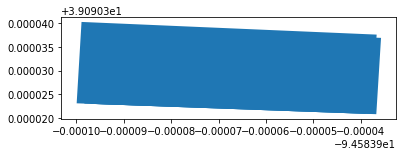

In [468]:
data_overlaps.loc[(data_overlaps.new_id_2.isin([104, 103, 102, 101])) & \
                 (data_overlaps.new_id_1.isin([100]))].plot()

In [471]:
k.loc[(k.new_id.isin([104, 103, 102, 101,100,105]))].plot()

In [538]:
kanton_map = folium.Map(location=[39.0903, -94.58404627591267],
                   tiles='cartodbpositron', zoom_start=11)
kanton_map
kanton_map.choropleth(geo_data='KSB.geojson')
kanton_map

In [484]:
cdf = pd.read_csv('sensity_events.csv')

In [485]:
cdf.head()

uuid       asset_id  \
0  SENSITY-kc-23-40D98DC1-41F8-40EE-BBB8-E44DE41C...  SENSITY-kc-23   
1  SENSITY-kc-22-E5EBBB3A-05E4-4D9C-97CB-26542918...  SENSITY-kc-22   
2  SENSITY-kc-10-C4D472BA-65CA-4D2B-A6C0-9C3981CD...  SENSITY-kc-10   
3  SENSITY-kc-12-4C26D1EC-4CCE-4E9A-87D1-D93149F5...  SENSITY-kc-12   
4  SENSITY-kc-9-CDDB22AD-31F6-4A11-BC94-CCC6602575A1   SENSITY-kc-9   

                start_time                    end_time session_type  \
0  2018-08-10 23:33:26.081    2018-08-10 23:33:55.9371          car   
1  2018-08-10 23:34:58.454  2018-08-10 23:36:08.256733          car   
2  2018-08-10 23:33:40.424  2018-08-10 23:36:25.890125          car   
3  2018-08-10 23:34:44.149  2018-08-10 23:38:53.829785          car   
4  2018-08-10 23:37:38.946  2018-08-10 23:39:01.415632          car   

    latitude  longitude                                           geometry  
0  39.109786 -94.583482  {"type":"Polygon","coordinates":[[[-94.5834598...  
1  39.109536 -94.580771  {"type":"Polygon","coordinates":[[[-94.5807547...  
2  39.094360 -94.583396  {"type":"Polygon","coordinates":[[[-94.5834062...  
3  39.095302 -94.583515  {"type":"Polygon","coordinates":[[[-94.5835249...  
4  39.092984 -94.583621  {"type":"Polygon","coordinates":[[[-94.5836287...

In [491]:
cdf['longitude']  cdf['latitude']

SyntaxError: invalid syntax (<ipython-input-491-ae00518c1d6b>, line 1)

In [494]:
([cdf['longitude'][0],cdf['latitude'][0]])

[-94.5834816617635, 39.10978592600429]

In [510]:
cdf.apply(lambda y: list([y['longitude'],y['latitude']]),axis=1).tolist()

[[-94.5834816617635, 39.10978592600429],
 [-94.5807712566161, 39.1095360461796],
 [-94.5833964061043, 39.094359928977106],
 [-94.5835153236837, 39.0953022307935],
 [-94.58362129721941, 39.0929837929106],
 [-94.58338088877122, 39.0974861273139],
 [-94.5836028038121, 39.1081229161611],
 [-94.5836298337034, 39.0895257143255],
 [-94.5834952209961, 39.0955491843685],
 [-94.5805071474366, 39.109129454214504],
 [-94.580498134005, 39.1090956785045],
 [-94.58348129632209, 39.0928727133682],
 [-94.58365084178172, 39.0922724582825],
 [-94.58340507044201, 39.094211013031504],
 [-94.5835072577362, 39.0921933031617],
 [-94.58350592106831, 39.0921194506509],
 [-94.5834876143458, 39.095554197552204],
 [-94.58336868630708, 39.097539565752605],
 [-94.58351248811181, 39.0952116283548],
 [-94.58338373646228, 39.0974316434289],
 [-94.58362720210229, 39.0896774910402],
 [-94.5834241169438, 39.0937827537638],
 [-94.5836168492973, 39.0930182834597],
 [-94.58349352290979, 39.100881894374204],
 [-94.58340184913

In [544]:
cdf.loc[(cdf['asset_id']=='SENSITY-kc-1') & (cdf['start_time']=='2018-11-03 13:30:00')].\
apply(lambda y: list([y['longitude'],y['latitude']]),axis=1).tolist()

AttributeError: 'DataFrame' object has no attribute 'tolist'

In [547]:
cdf['start_time'] = pd.to_datetime(cdf.start_time,format='%Y/%m/%d').astype('datetime64[s]')
cdf['end_time'] = pd.to_datetime(cdf.end_time,format='%Y/%m/%d').astype('datetime64[s]')

In [554]:
cdf.loc[(cdf['asset_id']=='SENSITY-kc-1') &(cdf['start_from_fc']=='2018-11-03 13:30:00')]

uuid      asset_id  \
121802  SENSITY-kc-1-8FC6AB26-2AC4-49C6-B3CE-69C756A461DD  SENSITY-kc-1   

                start_time            end_time session_type   latitude  \
121802 2018-11-03 13:30:59 2018-11-03 17:13:46          car  39.088894   

        longitude                                           geometry  \
121802 -94.583837  {"type":"Polygon","coordinates":[[[-94.5838458...   

             start_from_fc         end_from_fc  
121802 2018-11-03 13:30:00 2018-11-03 17:15:00

In [549]:
cdf['start_from_fc']= cdf.start_time.dt.floor('5min')
cdf['end_from_fc'] = cdf.end_time.dt.ceil('5min')

In [551]:
cdf

uuid       asset_id  \
0       SENSITY-kc-23-40D98DC1-41F8-40EE-BBB8-E44DE41C...  SENSITY-kc-23   
1       SENSITY-kc-22-E5EBBB3A-05E4-4D9C-97CB-26542918...  SENSITY-kc-22   
2       SENSITY-kc-10-C4D472BA-65CA-4D2B-A6C0-9C3981CD...  SENSITY-kc-10   
3       SENSITY-kc-12-4C26D1EC-4CCE-4E9A-87D1-D93149F5...  SENSITY-kc-12   
4       SENSITY-kc-9-CDDB22AD-31F6-4A11-BC94-CCC6602575A1   SENSITY-kc-9   
5       SENSITY-kc-14-EC9EB215-CFAC-437F-9FEE-CF8917FF...  SENSITY-kc-14   
6       SENSITY-kc-18-B6079A6A-B9EF-4080-B4D8-B2BA7099...  SENSITY-kc-18   
7       SENSITY-kc-2-2EB5BA3B-6629-4298-9D02-D292CE41641E   SENSITY-kc-2   
8       SENSITY-kc-12-012FEE39-6092-419F-B096-31FA7A37...  SENSITY-kc-12   
9       SENSITY-kc-21-8A06DAEC-A8E9-4996-8723-51570636...  SENSITY-kc-21   
10      SENSITY-kc-21-4A7750BE-5AA9-492D-B913-04ED44E5...  SENSITY-kc-21   
11      SENSITY-kc-8-A0436C6D-91A9-452B-8561-A1F44BF0C381   SENSITY-kc-8   
12      SENSITY-kc-9-04B89F44-D078-4E0D-8395-648BF0D779BB   SENSITY-kc-9   
13      SENSITY-kc-10-8273AE52-1D5F-4C86-820A-067FBE1F...  SENSITY-kc-10   
14      SENSITY-kc-8-936405B7-7462-46FD-B10E-09D22F407139   SENSITY-kc-8   
15      SENSITY-kc-8-1FE9FA74-7FC8-4721-BFD9-17A05014900E   SENSITY-kc-8   
16      SENSITY-kc-12-67CD92D1-1144-45D6-8938-12830A09...  SENSITY-kc-12   
17      SENSITY-kc-14-7B69BC78-1676-4132-A4DB-A0C4874B...  SENSITY-kc-14   
18      SENSITY-kc-12-1A22267D-E0F1-4CBF-99B7-AE3AFA38...  SENSITY-kc-12   
19      SENSITY-kc-14-49219653-B436-4ECF-87B2-CEDE9349...  SENSITY-kc-14   
20      SENSITY-kc-2-8FABCBD4-9024-4C48-9D88-2595443C86E8   SENSITY-kc-2   
21      SENSITY-kc-10-E84971B1-043E-4F45-9AEC-358240DD...  SENSITY-kc-10   
22      SENSITY-kc-9-E23BD89B-8118-4445-9FCC-772DA5DB7E15   SENSITY-kc-9   
23      SENSITY-kc-15-C71272E1-BD6E-4F68-83EB-18873CD7...  SENSITY-kc-15   
24      SENSITY-kc-10-463011E6-0068-464D-96FC-2800CEB4...  SENSITY-kc-10   
25      SENSITY-kc-23-66466105-BEA6-408A-8900-FDA4737C...  SENSITY-kc-23   
26      SENSITY-kc-14-D909FA91-A122-4289-928C-79CE91BC...  SENSITY-kc-14   
27      SENSITY-kc-10-0B3CB4D5-CDE5-4CCC-90B8-B5D802F8...  SENSITY-kc-10   
28      SENSITY-kc-10-DD5A7279-56BC-4771-BB59-DB591329...  SENSITY-kc-10   
29      SENSITY-kc-18-7F80957D-A9CA-407C-80FC-5913F6B6...  SENSITY-kc-18   
...                                                   ...            ...   
162094  SENSITY-kc-10-2F7882A5-C7C0-4AB8-A515-1177B625...  SENSITY-kc-10   
162095  SENSITY-kc-12-8FF5C8FE-B542-49CF-88E9-BC00A01B...  SENSITY-kc-12   
162096  SENSITY-kc-9-138FED19-AE19-412D-95A6-B41D5B6FF4ED   SENSITY-kc-9   
162097  SENSITY-kc-8-6CED1DB5-1AAC-40AB-8ABE-96ABFFA510B3   SENSITY-kc-8   
162098  SENSITY-kc-9-0996161E-466F-4AC2-9A57-8DB5AEFF2BDB   SENSITY-kc-9   
162099  SENSITY-kc-14-737064A2-2697-4950-A0E3-BF3758B4...  SENSITY-kc-14   
162100  SENSITY-kc-9-63608323-DA3F-4C86-A099-D9CAE8950D54   SENSITY-kc-9   
162101  SENSITY-kc-7-1D958CD7-578B-4968-A799-3FA5A34BF6A5   SENSITY-kc-7   
162102  SENSITY-kc-4-040F09B1-9C75-498E-ADFD-EAC1151CCC77   SENSITY-kc-4   
162103  SENSITY-kc-10-0C46FB05-47E0-4F7E-8BAE-B5775E99...  SENSITY-kc-10   
162104  SENSITY-kc-6-E6E0392A-2A48-4BE3-A90D-DBE6D8331609   SENSITY-kc-6   
162105  SENSITY-kc-19-D7613A2C-5EEB-4969-AC6F-3A0C8C0B...  SENSITY-kc-19   
162106  SENSITY-kc-2-B0337686-262D-4A70-933F-B6902018F339   SENSITY-kc-2   
162107  SENSITY-kc-19-43A62096-C768-4751-95B8-2D76E3D7...  SENSITY-kc-19   
162108  SENSITY-kc-6-73B6DF35-EE94-4DBA-8EDF-7E6EF877BA24   SENSITY-kc-6   
162109  SENSITY-kc-8-5CDB74F5-2F37-41E8-81B1-1D8F9DBA6F86   SENSITY-kc-8   
162110  SENSITY-kc-2-550877C2-A6E8-4DF2-89A4-1F53ED51C6DF   SENSITY-kc-2   
162111  SENSITY-kc-15-33E1D598-BCC3-40FC-952C-CCE804AF...  SENSITY-kc-15   
162112  SENSITY-kc-2-5D1781B7-C01A-46C8-A681-214FE9FE2FCE   SENSITY-kc-2   
162113  SENSITY-kc-4-E88AF864-6AFD-4BD1-8630-8982D4949945   SENSITY-kc-4   
162114  SENSITY-kc-12-137A56F8-18ED-4BFE-A572-F7993CED...  SENSITY-kc-12   
162115  SENSITY-kc-10-FA4